# Basic Usage - Finding Molecular Formulae

`find_mfs` is a Python implementation of Böcker & Lipták's algorithm for finding molecular formulae candidates which fit some given mass (+/- an error window). `find_mfs` also implements other methods for filtering the candidate lists:
- Checking whether a molecular formulae satisfies the octet rule
- Filtering by ring/double bond equivalents (RDBE's)
- Filtering by predicted isotope envelopes, generated using  using Łącki and Startek's algorithm as implemented in `IsoSpecPy`

---

**If you use this package, make sure to cite:**
- [Böcker & Lipták, 2007](https://link.springer.com/article/10.1007/s00453-007-0162-8) - this package uses their algorithm for formula finding...
    - ...as implemented in SIRIUS: [Böcker et. al., 2008](https://academic.oup.com/bioinformatics/article/25/2/218/218950)
- [Łącki, Valkenborg & Startek 2020](https://pubs.acs.org/doi/10.1021/acs.analchem.0c00959) - this package uses IsoSpecPy to quickly simulate isotope envelopes
- [Gohlke, 2025](https://zenodo.org/records/17059777) - this package uses `molmass`, which provides very convenient methods for handling chemical formulae

---

## Finding Molecular Formulae

A `FormulaFinder` instance must be initialized like so:

In [28]:
from find_mfs import FormulaFinder

# Initializing a FormulaFinder uses CHNOPS elements by default
finder = FormulaFinder()

results = finder.find_formulae(
    mass=613.2391,         # Novobiocin [M+H]+ ion; C31H37N2O11+
    charge=1,              # Charge should be specified - electron mass matters
    error_ppm=5.0,         # Can also specify error_da instead
                           # --- FORMULA FILTERS ----
    check_octet=True,      # Candidates must obey the octet rule
    filter_rdbe=(0, 20),   # Candidates must have 0 to 20 ring/double-bond equivalents
    max_counts={
        'P': 0,            # Candidates must not have any phosophorous atoms
        'S': 2,            # Candidates can have up to two sulfur atoms
    },
)

print(results)

FormulaSearchResults(query_mass=613.2391, n_results=38)

Formula                   Error (ppm)     Error (Da)      RDBE      
----------------------------------------------------------------------
[C6H25N30O4S]+                     -0.12       0.000073       9.5
[C31H37N2O11]+                      0.14       0.000086      14.5
[C14H29N24OS2]+                     0.18       0.000110      12.5
[C16H41N10O11S2]+                   0.20       0.000121       1.5
[C29H33N12S2]+                     -0.64       0.000392      19.5
... and 33 more


In [29]:
finder.find_formulae(
    mass=635.22113,        # Novobiocin [M+Na]+ ion; C31H36N2O11Na+
    charge=1,              # Charge should be specified - electron mass matters
    error_ppm=5.0,         # Can also specify error_da instead
    adduct='Na',
)

FormulaSearchResults(query_mass=635.2211, n_results=2425)

Formula                   Error (ppm)     Error (Da)      RDBE      
----------------------------------------------------------------------
[C31H36N2NaO11]+                    0.00       0.000001      14.5
[C2H64N10NaO4S10]+                  0.00       0.000003     -24.5
[C30H30N9NaO6]+                    -0.01       0.000005      20.0
[H50N14NaO13P2S3]+                  0.01       0.000006     -14.5
[C4H66N3NaO11P8S]+                 -0.01       0.000007     -15.0
... and 2420 more

In [30]:
finder.find_formulae(
    mass=647.20131,        # Novobiocin [M+Cl]- ion; C31H36N2O11Cl-
    charge=-1,             # Charge should be specified - electron mass matters
    error_ppm=5.0,         # Can also specify error_da instead
    adduct='Cl',
)

FormulaSearchResults(query_mass=647.2013, n_results=2475)

Formula                   Error (ppm)     Error (Da)      RDBE      
----------------------------------------------------------------------
[C31H36ClN2O11]-                    0.00       0.000001      14.5
[C2H64ClN10O4S10]-                  0.01       0.000004     -24.5
[C30H30ClN9O6]-                    -0.01       0.000004      20.0
[ClH50N14O13P2S3]-                  0.01       0.000007     -14.5
[C4H66ClN3O11P8S]-                 -0.01       0.000007     -15.0
... and 2470 more

In [33]:
# Alternatively, min_ and max_counts can be given as formulae. This is useful for assigning ion fragment formulae:
finder.find_formulae(
    mass=189.09133,           # Fragment of Novobiocin [M+H]+ ion
    charge=1,              
    error_ppm=5.0,
    max_counts='C31H37N2O11', # The MF candidates can't have any atoms that aren't in the parent
    check_octet=True,
    filter_rdbe=(0, 20),
)

FormulaSearchResults(query_mass=189.0913, n_results=1)

Formula                   Error (ppm)     Error (Da)      RDBE      
----------------------------------------------------------------------
[C12H13O2]+                        -1.71       0.000324       6.5

## Formula Search Results

`find_formulae()` returns a `FormulaSearchResults` object, which implements some useful methods:

In [34]:
# Results can be further reduced by chaining filters, like so:
constrained_results = (
    results
    .filter_by_error(max_ppm=1.0)  # Tighter error window (also accepts max_da)
    .filter_by_rdbe(5, 20)         # Adjusting RBDE range
    .top(5)                        # Keep the top 5 results
)

print(constrained_results)

FormulaSearchResults(query_mass=613.2391, n_results=5)

Formula                   Error (ppm)     Error (Da)      RDBE      
----------------------------------------------------------------------
[C6H25N30O4S]+                     -0.12       0.000073       9.5
[C31H37N2O11]+                      0.14       0.000086      14.5
[C14H29N24OS2]+                     0.18       0.000110      12.5
[C29H33N12S2]+                     -0.64       0.000392      19.5
[C23H41N4O13S]+                    -0.92       0.000565       5.5


In [35]:
# If Pandas is installed, results can be converted into a DataFrame
df = results.to_dataframe()
df.head()

,formula,error_ppm,error_da,rdbe,mass
0,[C6H25N30O4S]+,-0.119021,0.000073,9.5,613.239027
1,[C31H37N2O11]+,0.140951,0.000086,14.5,613.239186
2,[C14H29N24OS2]+,0.180076,0.000110,12.5,613.239210
3,[C16H41N10O11S2]+,0.197231,0.000121,1.5,613.239221
4,[C29H33N12S2]+,-0.639416,0.000392,19.5,613.238708


## Molecular Formulae Candidates
`FormulaSearchResults` is a container for `FormulaCandidate` objects, which have the following attributes:

In [36]:
mf_candidate = results[0]

for tag, attribute in (
    ("Formula: ", mf_candidate.formula),
    ("Error (ppm): ", round(mf_candidate.error_ppm, 2)),  
    ("Error (Da): ", round(mf_candidate.error_da, 5)),
    ("RDBE: ", mf_candidate.rdbe),
):
    print(f"{tag:<20}{attribute}")

Formula:            [H25C6N30O4S1]+
Error (ppm):        -0.12
Error (Da):         7e-05
RDBE:               9.5


In [37]:
# `find_mfs` uses the `molmass` library, which has some useful features:
formula = mf_candidate.formula

# Here are some examples. Be sure to check out the molmass documentation
for tag, attribute in (
    ("Empirical formula: ", formula.empirical),
    ("Charge: ", formula.charge),
    ("Number of atoms: ", formula.atoms),
    ("Nominal mass: ", formula.nominal_mass),
):
    print(f"{tag:<20}{attribute}")

print(
    f"\n As dataframe:"
)
formula.composition().dataframe()

Empirical formula:  [C6H25N30O4S]+
Charge:             1
Number of atoms:    66
Nominal mass:       613

 As dataframe:


,Count,Relative mass,Fraction
Element,,,
C,6,72.064440,1.174595e-01
H,25,25.198525,4.107165e-02
N,30,420.201090,6.848954e-01
O,4,63.997620,1.043112e-01
S,1,32.064800,5.226315e-02
e-,-1,-0.000549,-8.941430e-07


## Filtering Using Isotope Patterns

Even with <1.0 ppm mass accuracy, it's usually not possible to assign molecular formulae based on mass alone. An easy way to get around this is to filter down the candidate list by comparing predicted/observed isotope envelopes (see: [Kind & Fiehn 2006](https://link.springer.com/article/10.1186/1471-2105-7-234)).

`find_mfs` implements such filtering, using [IsoSpecPy](http://matteolacki.github.io/IsoSpec/) to simulate isotope envelopes.

**If you use this functionality, make sure to cite the IsoSpec2 paper!** ([Łącki, Valkenborg & Startek 2020](https://pubs.acs.org/doi/10.1021/acs.analchem.0c00959))

---

In the following example, a single isotope envelope observation is used:

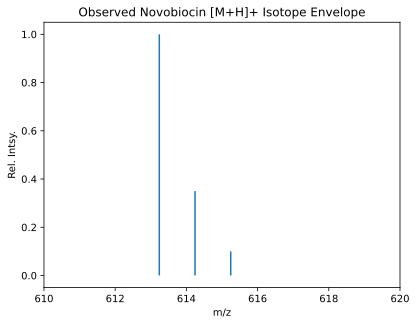

In [38]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
import numpy as np

# Isotope envelope for novobiocin's [M+H]+ ion (C31H37N2O11+)
observed_envelope = np.array(
    [  #  m/z    , relative intsy.
        [613.2397,    1.00],
        [614.2429,    0.35],
        [615.2456,    0.10],
    ]
)

plt.xlabel('m/z')
plt.ylabel('Rel. Intsy.')
plt.title(
    'Observed Novobiocin [M+H]+ Isotope Envelope'
)
plt.xlim(610, 620)
plot = plt.stem(
    observed_envelope[:, 0],
    observed_envelope[:, 1],
    markerfmt=' ',
    basefmt=' ',
)

In [39]:
# To use isotope matching, parameters must be defined like so:
from find_mfs import SingleEnvelopeMatch

iso_config = SingleEnvelopeMatch(
    envelope=observed_envelope,    # np.ndarray with an m/z column and an intensity column
    mz_tolerance_ppm=5.0,          # Maximum m/z error tolerance for each isotopoogue signal (in ppm)
    # mz_tolerance_da=0.01,        # Tolerance can also be given in Da
    intensity_tolerance=0.05,      # Maximum relative intensity tolerance (i.e isotope ratio deviation)
)

iso_matched_results = finder.find_formulae(
    mass=613.2391,         # Novobiocin [M+H]+ ion; C31H37N2O11+
    charge=1,              # Charge should be specified - electron mass matters
    error_ppm=1.0,         # Can also specify error_da instead
                           # --- FORMULA FILTERS ----
    check_octet=True,      # Candidates must obey the octet rule
    filter_rdbe=(0, 20),   # Candidates must have 0 to 20 ring/double-bond equivalents
    max_counts={
        'P': 0,            # Candidates must not have any phosophorous atoms
        'S': 2,            # Candidates can have up to two sulfur atoms
    },
    isotope_match=iso_config,
)

print(iso_matched_results)

FormulaSearchResults(query_mass=613.2391, n_results=3)

Formula                   Error (ppm)     Error (Da)      RDBE       Iso. Matches
------------------------------------------------------------------------------------------
[C31H37N2O11]+                      0.14       0.000086      14.5         3/3
[C24H37N8O9S]+                      1.26       0.000772      10.5         2/3
[C32H41N2O6S2]+                     1.56       0.000956      13.5         2/3


In [40]:
# Finally, if the results contain isotope envelope matches, they can be filtered like so:
iso_matched_results.filter_by_isotope_quality(
    min_match_fraction=1.00,  # Only show MF candidates that matched ALL of the observed isotope envelope
)

FormulaSearchResults(query_mass=613.2391, n_results=1)

Formula                   Error (ppm)     Error (Da)      RDBE       Iso. Matches
------------------------------------------------------------------------------------------
[C31H37N2O11]+                      0.14       0.000086      14.5         3/3

**An explanation for the isotope envelope filtering**

To visualize how the filter works, consider the plot from above (showing real data from a mass spectrometer), overlaid with *predicted* isotope patterns generated from all the MF candidates:

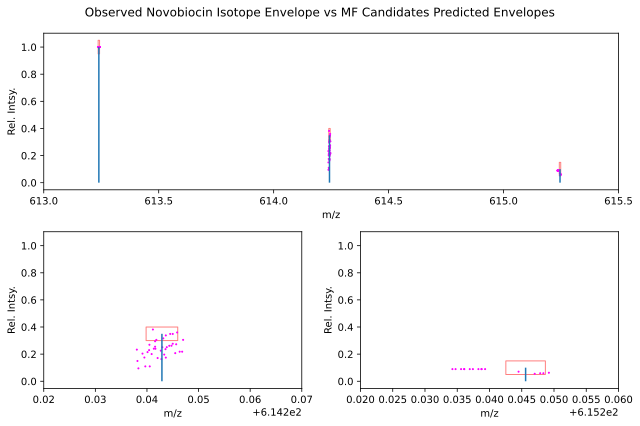

In [56]:
fig, axs = plt.subplot_mosaic(
    [['top', 'top'],
     ['left', 'right']],
    figsize=(9,6)
)

fig.suptitle(
    "Observed Novobiocin Isotope Envelope vs MF Candidates Predicted Envelopes"
)

# Several plots with different view ranges
axs['top'].set_xlim(613, 615.5)       # Entire isotope envelope
axs['left'].set_xlim(614.22, 614.27)  # M1
axs['right'].set_xlim(615.22, 615.26)  # M2
for ax in axs.values():
    ax.set_xlabel('m/z')
    ax.set_ylabel('Rel. Intsy.')
    
    ax.stem(
        observed_envelope[:, 0],
        observed_envelope[:, 1],
        markerfmt=' ',
        basefmt=' ',
    )
    
    # Draw rectangles representing the mz/intensity tolerances
    from matplotlib.patches import Rectangle
    
    MZ_TOLERANCE = 5e-6 * 613   # A 5 ppm window was used in above example
    INTSY_TOLERANCE = 0.05      # A 5% relative intensity window was used in above example
    
    for mz, intsy in observed_envelope:
        rect = Rectangle(
            (mz - MZ_TOLERANCE, intsy - INTSY_TOLERANCE),
            2 * MZ_TOLERANCE,
            2 * INTSY_TOLERANCE,
            ec='r', fc='none', alpha=0.5
        )
    
        ax.add_patch(rect)
    
    
    # This would normally not be done, but here it is for demonstration:
    from find_mfs import get_isotope_envelope
    for result in results:
        predicted_isotope_envelope = get_isotope_envelope(
                formula=result.formula,
                mz_tolerance=0.01,
                threshold=0.05,
        )
    
        ax.scatter(
            predicted_isotope_envelope[:, 0],
            predicted_isotope_envelope[:, 1],
            marker='.',
            s=5,
            color='magenta',
        )

plt.tight_layout()

## A Note About Defining Element Sets

Böcker & Lipták's algorithm involves first constructing an *extended residue table* (ERT) using the elements to be considered during decomposition. This computation is done upfront, and dramatically speeds up formula finding later. However, constructing the residue table can take a few seconds.

For common element sets (i.e. 'CHNOPS' and 'CHNOPSFBrClI'), a pre-calculated ERT is retrieved, to save time. If the user is specifying a different element set, please note that initializing `FormulaFinder(...)` can take a few seconds - so make sure you don't put that inside a loop.

**More importantly, if the user wishes to include a *subset* of CHNOPS or CHNOPS + Halogens, it's more efficient to just specify element limits rather than constructing an entire new element set, like so:**

In [27]:
halogen_finder = FormulaFinder("CHNOPSBrClIF")   # Fast, loads pre-calculated ERT

halogen_finder.find_formulae(
    mass = 289.0950,  # Chlorotetaine [M+H]+ ion; C12H18ClN2O4+
    error_ppm=5.0,
    charge=1,
    min_counts = {
        'Cl': 1,
    },
    max_counts = {    # Results only contain Cl, and not other halogens
        'F': 0,
        'Br': 0,
        'I': 0,
    },
    check_octet=True,
)

FormulaSearchResults(query_mass=289.0950, n_results=29)

Formula                   Error (ppm)     Error (Da)      RDBE      
----------------------------------------------------------------------
[C12H18ClN2O4]+                    -0.13       0.000039       4.5
[CH25Cl4N8]+                        0.28       0.000080      -8.5
[Cl3H25N8OP]+                      -0.33       0.000096      -7.5
[C4H32ClO3P2S2]+                    0.40       0.000115      -8.5
[C5H26ClN4OS3]+                     0.62       0.000179      -5.5
... and 24 more